In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
IMAGE_SIZE = 300
CHANNELS = 3
EPOCHS = 10
BATCH_SIZE = 4
CLASS_LABEL = ['Not Potato leaf', 'Potato leaf']

In [3]:
image_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/isPotatoLeaf/*/*', shuffle=False)

In [4]:
len(image_ds)

4303

In [5]:
for file in image_ds.take(5):
    print(file.numpy())

b'/content/drive/MyDrive/isPotatoLeaf/0/0.jpg'
b'/content/drive/MyDrive/isPotatoLeaf/0/000_339273E.jpg'
b'/content/drive/MyDrive/isPotatoLeaf/0/0x0.jpg'
b'/content/drive/MyDrive/isPotatoLeaf/0/102.jpg'
b'/content/drive/MyDrive/isPotatoLeaf/0/105.jpg'


In [6]:
image_ds = image_ds.shuffle(10000)
for file in image_ds.take(10):
    print(file.numpy())

b'/content/drive/MyDrive/isPotatoLeaf/1/996c0f04-a33a-4620-8971-469e009abae7___RS_Early.B 8869.JPG'
b'/content/drive/MyDrive/isPotatoLeaf/0/3297.jpg'
b'/content/drive/MyDrive/isPotatoLeaf/0/4551.jpg'
b'/content/drive/MyDrive/isPotatoLeaf/1/03bab48b-962b-4c08-bc98-da95237d20ac___RS_LB 3190.JPG'
b'/content/drive/MyDrive/isPotatoLeaf/0/2415.jpg'
b'/content/drive/MyDrive/isPotatoLeaf/1/9cd81447-0701-4969-86aa-5f20269923c5___RS_Early.B 8790.JPG'
b'/content/drive/MyDrive/isPotatoLeaf/1/a89d6e67-d60e-49b5-8b87-e137b6a5181c___RS_Early.B 7472.JPG'
b'/content/drive/MyDrive/isPotatoLeaf/1/beb20b26-07f9-4215-8264-dca1283514ac___RS_Early.B 7644.JPG'
b'/content/drive/MyDrive/isPotatoLeaf/0/2538.jpg'
b'/content/drive/MyDrive/isPotatoLeaf/0/4953.jpg'


In [7]:
for file in image_ds.take(1):
    print(tf.strings.split(file, os.path.sep))

tf.Tensor(
[b'' b'content' b'drive' b'MyDrive' b'isPotatoLeaf' b'1'
 b'f194debe-e829-4bfb-af09-681e50358f50___RS_Early.B 7739.JPG'], shape=(7,), dtype=string)


In [8]:
def get_label(file_path):
    return tf.strings.split(file_path, os.path.sep)[-2]

In [9]:
def process_image(file_path):
    label = int(get_label(file_path))

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMAGE_SIZE,IMAGE_SIZE])

    return img, label

In [10]:
dataset = image_ds.map(process_image).batch(BATCH_SIZE)

In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(4, 300, 300, 3)
[1 0 1 1]


Data visualization

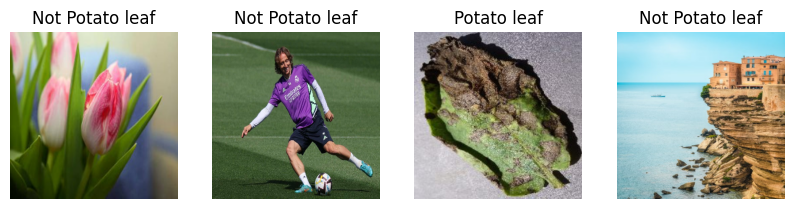

In [12]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title(CLASS_LABEL[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))

In [13]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, shuffle=True,  shuffle_size=5000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [15]:
len(train_ds), len(test_ds), len(val_ds)

(860, 109, 107)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescaling = tf.keras.Sequential([
    keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.Rescaling(1.0/255.0)
])

data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
  ]
)

In [18]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model = keras.Sequential([
    resize_and_rescaling,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),


    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [21]:
history = model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)
history

Epoch 1/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 841s 769ms/step - accuracy: 0.7674 - loss: 0.4282 - val_accuracy: 0.9556 - val_loss: 0.0975
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 639s 712ms/step - accuracy: 0.9632 - loss: 0.1130 - val_accuracy: 0.9673 - val_loss: 0.0782
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 603s 702ms/step - accuracy: 0.9793 - loss: 0.0755 - val_accuracy: 0.9439 - val_loss: 0.1956
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 620s 699ms/step - accuracy: 0.9805 - loss: 0.0627 - val_accuracy: 0.9626 - val_loss: 0.0951
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 620s 697ms/step - accuracy: 0.9744 - loss: 0.0729 - val_accuracy: 0.9836 - val_loss: 0.0393
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 601s 699ms/step - accuracy: 0.9829 - loss: 0.0514 - val_accuracy: 0.9626 - val_loss: 0.0993
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 622s 698ms/step - accuracy: 0.9782 - loss: 0.0671 - val_accuracy: 0.9813 - val_loss: 0.0749
Epoch 8/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 621s 697ms/step - accuracy: 0.9813 -

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

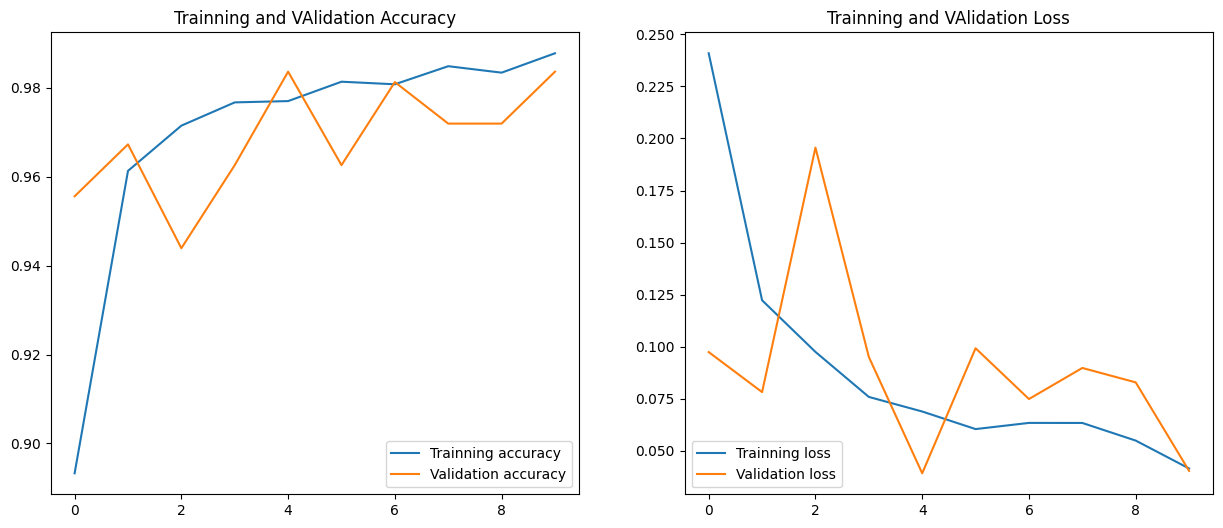

In [23]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Trainning accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Trainning and VAlidation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Trainning loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='lower left')
plt.title('Trainning and VAlidation Loss')
plt.show()

first image to predict
first image's actual label:  Potato leaf
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Potato leaf


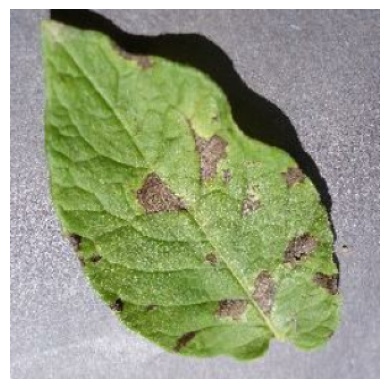

In [25]:
for image_batch, label_batch in dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    plt.axis('off')
    print('first image to predict')
    plt.imshow(first_image)
    print("first image's actual label: ", CLASS_LABEL[first_label])

    batch_prediction = model.predict(image_batch)
    print(CLASS_LABEL[np.argmax(batch_prediction[0])])

In [26]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = CLASS_LABEL[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

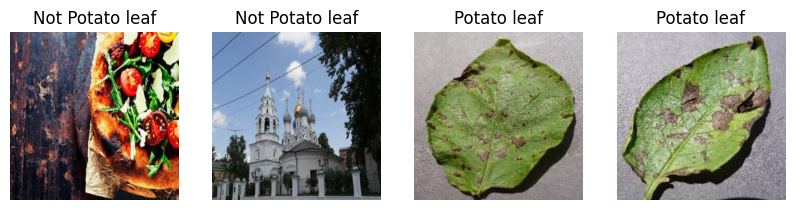

In [27]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(3,4,i+1)
        plt.axis('off')
        plt.title(CLASS_LABEL[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


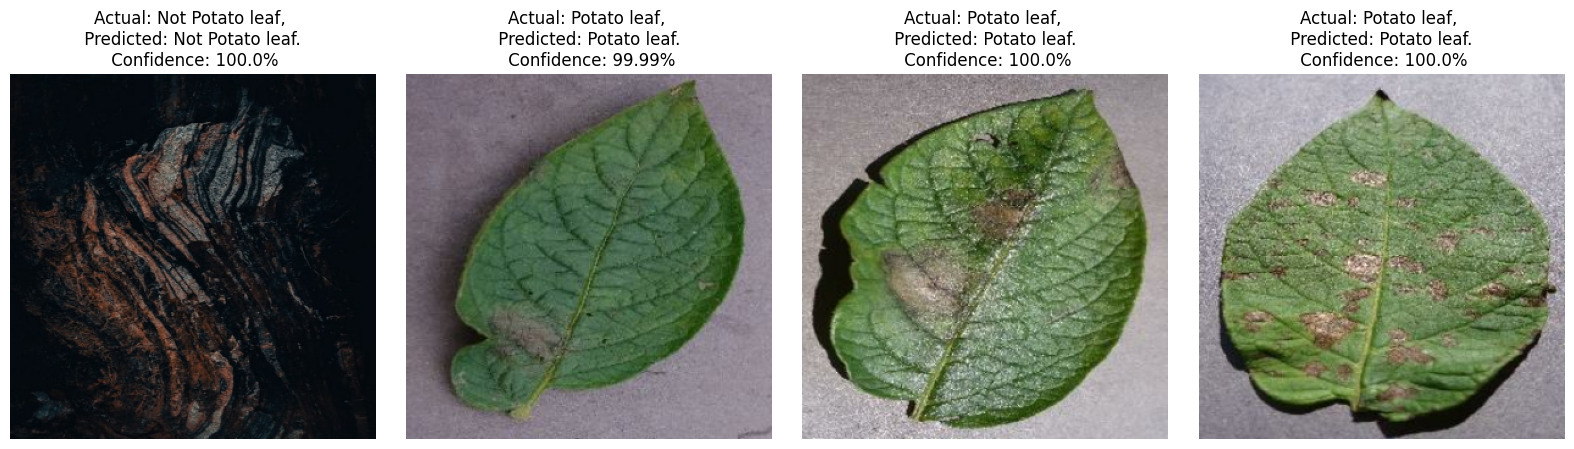

In [28]:
plt.figure(figsize=(16,16))
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = CLASS_LABEL[labels[i]]

        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%')
        plt.axis('off')
        plt.tight_layout()

In [29]:
model.save('model.keras', save_format='keras')